# Covid-19 India Analysis

## Libraries

In [246]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [454]:
## API links from covid19india.org

state_cases_url = "https://api.covid19india.org/csv/latest/state_wise.csv"
state_daily_cases_url = "https://api.covid19india.org/csv/latest/state_wise_daily.csv"
state_daily_tests_url = "https://api.covid19india.org/csv/latest/statewise_tested_numbers_data.csv"

In [455]:
df_state_cases_raw = pd.read_csv(state_cases_url)
df_state_daily_cases_raw = pd.read_csv(state_daily_cases_url)
df_state_daily_tests_raw = pd.read_csv(state_daily_tests_url)

In [261]:
test = df_state_daily_tests_raw

In [294]:
test['date1'] = pd.to_datetime(test.loc[test['Updated On'].astype(str).str.extract('.*(\d{2})', expand = False).astype(int)>12, 
                     'Updated On'], format='%Y-%m-%d')
test['date2'] = pd.to_datetime(test.loc[test['Updated On'].astype(str).str.extract('.*(\d{2})', expand = False).astype(int)<=12, 
                     'Updated On'], format='%Y-%d-%m')

In [383]:
test['date2'] = pd.to_datetime(test['date2'], format='%Y-%d-%m')

In [387]:
test['date']=test["date1"].fillna(test["date2"])


In [393]:
df_state_daily_tests_raw['Date'] = test['date']

## Preprocess

### Statewise counts

In [19]:
df_state_cases.head()

,State,Confirmed,Recovered,Deaths,Active,Last_Updated_Time,Migrated_Other,State_code,Delta_Confirmed,Delta_Recovered,Delta_Deaths,State_Notes
0,Total,321626,162326,9199,150064,14/06/2020 00:24:46,37,TT,12031,8091,309,NaN
1,Maharashtra,104568,49346,3830,51379,13/06/2020 22:43:48,13,MH,3427,1550,113,13 cases were marked as non-covid deaths in MH...
2,Tamil Nadu,42687,23409,397,18881,13/06/2020 19:24:48,0,TN,1989,1362,30,2 deaths cross notified to other states from C...
3,Delhi,38958,14945,1271,22742,13/06/2020 22:14:19,0,DL,2134,1547,57,"Delhi bulletins in the morning, containing dat..."
4,Gujarat,23079,15891,1449,5739,13/06/2020 20:15:50,0,GJ,517,390,33,NaN


In [76]:
# Mapping table state code to state
df_map = df_state_cases_raw[['State', 'State_code']]

In [42]:
#Filter only state name & total case statistics
df_state_cases = df_state_cases_raw[df_state_cases_raw['State']!="Total"][[
    'State', 'State_code', 'Confirmed', 'Recovered', 'Deaths', 'Active']]

In [188]:
#Defining percentage measures of deaths & active cases
df_state_cases['death_rate'] = df_state_cases['Deaths']*100/df_state_cases['Confirmed']
df_state_cases['death_rate_active'] = df_state_cases['Deaths']*100/df_state_cases['Recovered']
df_state_cases['active_rate'] = df_state_cases['Active']*100/df_state_cases['Confirmed']

### Statewise daily data

In [79]:
df_state_daily_cases_raw.head()

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,14-Mar-20,Recovered,9,0,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
2,14-Mar-20,Deceased,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15-Mar-20,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
4,15-Mar-20,Recovered,4,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0


In [216]:
df_state_daily_cases_raw['Date'] = pd.to_datetime(df_state_daily_cases_raw['Date'])

In [217]:
df_state_daily_cases_raw_melt = df_state_daily_cases_raw.melt(id_vars=['Date', 'Status'])
df_state_daily_cases_raw_melt = pd.merge(df_state_daily_cases_raw_melt, df_map, left_on='variable', right_on='State_code')
df_state_daily_cases_raw_melt.drop(columns=['variable'], inplace=True)

In [218]:
# Get statewise daily counts
df_temp = df_state_daily_cases_raw_melt[~df_state_daily_cases_raw_melt['State_code'].isin(['TT', 'UN'])]

df_state_daily_cases = df_temp[df_temp['Status']=='Confirmed'].reset_index(drop=True).drop(columns=['Status'])
df_state_daily_recovered = df_temp[df_temp['Status']=='Recovered'].reset_index(drop=True).drop(columns=['Status'])
df_state_daily_deaths = df_temp[df_temp['Status']=='Deaths'].reset_index(drop=True).drop(columns=['Status'])

In [219]:
# Get total daily counts
df_temp = df_state_daily_cases_raw_melt[df_state_daily_cases_raw_melt['State_code']=='TT']

df_total_daily_cases = df_temp[df_temp['Status']=='Confirmed'].reset_index(drop=True).drop(columns=['Status'])
df_total_daily_recovered = df_temp[df_temp['Status']=='Recovered'].reset_index(drop=True).drop(columns=['Status'])
df_total_daily_deaths = df_temp[df_temp['Status']=='Deceased'].reset_index(drop=True).drop(columns=['Status'])

In [220]:
df_state_daily_cases_raw_melt.State_code.unique()

array(['TT', 'AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN', 'DL', 'GA',
       'GJ', 'HR', 'HP', 'JK', 'JH', 'KA', 'KL', 'LA', 'LD', 'MP', 'MH',
       'MN', 'ML', 'MZ', 'NL', 'OR', 'PY', 'PB', 'RJ', 'SK', 'TN', 'TG',
       'TR', 'UP', 'UT', 'WB', 'UN'], dtype=object)

In [221]:
df_total_daily_cases.head()

,Date,value,State,State_code
0,2020-03-14,81,Total,TT
1,2020-03-15,27,Total,TT
2,2020-03-16,15,Total,TT
3,2020-03-17,11,Total,TT
4,2020-03-18,37,Total,TT


## Daily cumulative Statewise tests

In [394]:
df_state_daily_tests_raw.sample(10)

,Updated On,State,Total Tested,Tag (Total Tested),Positive,Negative,Unconfirmed,Cumulative People In Quarantine,Total People Currently in Quarantine,Tag (People in Quarantine),...,Test positivity rate,Tests per thousand,Tests per million,Tests per positive case,Population NCP 2019 Projection,tests,date1,date2,date,Date
1363,2020-11-04,Nagaland,70.0,Samples Sent,0.0,70.0,0.0,NaN,22.0,Facility,...,0.00%,0.03,33.0,NaN,2150000.0,70.0,NaT,2020-04-11,2020-04-11,2020-04-11
1648,2020-04-05,Rajasthan,129258.0,Reports Received,3061.0,122513.0,3684.0,NaN,NaN,NaN,...,2.37%,1.67,1673.0,42.0,77264000.0,125574.0,NaT,2020-05-04,2020-05-04,2020-05-04
281,2020-04-15,Chandigarh,317.0,Tested,21.0,293.0,2.0,NaN,NaN,NaN,...,6.62%,0.27,269.0,15.0,1179000.0,315.0,2020-04-15,NaT,2020-04-15,2020-04-15
618,2020-05-20,Gujarat,160772.0,Tested,12539.0,148233.0,0.0,NaN,476084.0,All Included,...,7.80%,2.37,2367.0,13.0,67936000.0,160772.0,2020-05-20,NaT,2020-05-20,2020-05-20
805,2020-07-05,Jammu and Kashmir,37706.0,Reports Received,793.0,36913.0,0.0,NaN,186.0,Hospital,...,2.10%,2.86,2856.0,48.0,13203000.0,37706.0,NaT,2020-05-07,2020-05-07,2020-05-07
1216,2020-11-06,Maharashtra,610790.0,Tested,94041.0,509990.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,610790.0,NaT,2020-06-11,2020-06-11,2020-06-11
651,2020-04-14,Haryana,5210.0,Samples Sent,184.0,3681.0,1345.0,NaN,NaN,NaN,...,3.53%,0.18,182.0,28.0,28672000.0,3865.0,2020-04-14,NaT,2020-04-14,2020-04-14
1903,2020-05-29,Uttar Pradesh,270920.0,Samples Sent,7445.0,261911.0,1564.0,NaN,9556.0,Institutional,...,2.75%,1.20,1204.0,36.0,224979000.0,269356.0,2020-05-29,NaT,2020-05-29,2020-05-29
1872,2020-04-28,Uttar Pradesh,70307.0,Samples Sent,2053.0,67266.0,988.0,NaN,11487.0,Institutional,...,2.92%,0.31,313.0,34.0,224979000.0,69319.0,2020-04-28,NaT,2020-04-28,2020-04-28
1639,2020-04-25,Rajasthan,78993.0,Reports Received,2083.0,71806.0,5104.0,NaN,NaN,NaN,...,2.64%,1.02,1022.0,38.0,77264000.0,73889.0,2020-04-25,NaT,2020-04-25,2020-04-25


In [223]:
df_state_daily_tests_raw.columns

Index(['Updated On', 'State', 'Total Tested', 'Tag (Total Tested)', 'Positive',
       'Negative', 'Unconfirmed', 'Cumulative People In Quarantine',
       'Total People Currently in Quarantine', 'Tag (People in Quarantine)',
       'Total People Released From Quarantine', 'People in ICU',
       'People on Ventilators', 'Num Isolation Beds', 'Num ICU Beds',
       'Num Ventilators', 'Total PPE', 'Total N95 Masks',
       'Corona Enquiry Calls', 'Num Calls State Helpline', 'Source1',
       'Unnamed: 21', 'Source2', 'Test positivity rate', 'Tests per thousand',
       'Tests per million', 'Tests per positive case',
       'Population NCP 2019 Projection', 'tests'],
      dtype='object')

In [225]:
#Convert Updated on to Date format
df_state_daily_tests_raw['Updated On'] = pd.to_datetime(df_state_daily_tests_raw['Updated On'])

In [226]:
df_state_daily_tests_raw['State'].unique()

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
       'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu',
       'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
       'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
       'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan',
       'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh',
       'Uttarakhand', 'West Bengal'], dtype=object)

In [227]:
df_state_daily_tests_raw['Tag (Total Tested)'].unique()

array(['Samples Sent', nan, 'Tested', 'Samples Collected',
       'Reports Received'], dtype=object)

In [228]:
df_state_daily_tests_raw['Unconfirmed'].fillna(0, inplace=True)
df_state_daily_tests_raw['Total Tested'].fillna(0, inplace=True)
df_state_daily_tests_raw['tests'] = df_state_daily_tests_raw['Total Tested']-df_state_daily_tests_raw['Unconfirmed']

In [395]:
df_state_daily_tests = df_state_daily_tests_raw[
    df_state_daily_tests_raw['Tag (Total Tested)'].isin(
        ['Samples Sent', 'Tested', 'Samples Collected', 'Reports Received'])][['Date', 'State', 'tests', 'Positive', 'Unconfirmed']]

In [396]:
df_state_daily_tests = pd.merge(df_state_daily_tests, df_map, left_on='State', right_on='State' )

In [397]:
df_state_daily_tests.head()

,Date,State,tests,Positive,Unconfirmed,State_code
0,2020-04-17,Andaman and Nicobar Islands,1222.0,12.0,181.0,AN
1,2020-04-24,Andaman and Nicobar Islands,2433.0,27.0,246.0,AN
2,2020-04-27,Andaman and Nicobar Islands,2742.0,33.0,106.0,AN
3,2020-05-01,Andaman and Nicobar Islands,3555.0,33.0,199.0,AN
4,2020-05-16,Andaman and Nicobar Islands,6541.0,33.0,136.0,AN


## Summary of Tables

### Total daily cases, deaths, recoveries

In [235]:
## Total counts - daily total counts of cases, deaths & recoveries

df_total_daily_cases.sample(5)

# Similarly, df_total_daily_deaths & df_total_daily_recovered

,Date,value,State,State_code
63,2020-05-16,4794,Total,TT
82,2020-06-04,9847,Total,TT
49,2020-05-02,2564,Total,TT
39,2020-04-22,1292,Total,TT
48,2020-05-01,2396,Total,TT


### Statewise cases, deaths, recoveries

In [109]:
df_state_cases.head()

,State,State_code,Confirmed,Recovered,Deaths,Active
1,Maharashtra,MH,104568,49346,3830,51379
2,Tamil Nadu,TN,42687,23409,397,18881
3,Delhi,DL,38958,14945,1271,22742
4,Gujarat,GJ,23079,15891,1449,5739
5,Uttar Pradesh,UP,13118,7875,385,4858


### Statewise daily cases, deaths, recoveries

In [232]:
df_state_daily_cases.head()

,Date,value,State,State_code
0,2020-03-14,0,Andaman and Nicobar Islands,AN
1,2020-03-15,0,Andaman and Nicobar Islands,AN
2,2020-03-16,0,Andaman and Nicobar Islands,AN
3,2020-03-17,0,Andaman and Nicobar Islands,AN
4,2020-03-18,0,Andaman and Nicobar Islands,AN


In [233]:
## Similarly, df_state_daily_deaths & df_state_daily_recovered

### Statewise daily cumulative tests

In [398]:
df_state_daily_tests.sample(5)

,Date,State,tests,Positive,Unconfirmed,State_code
896,2020-04-08,Karnataka,6967.0,181.0,0.0,KA
856,2020-05-06,Jharkhand,15908.0,127.0,0.0,JH
270,2020-04-11,Chandigarh,243.0,19.0,21.0,CH
1621,2020-04-26,Rajasthan,77855.0,2185.0,5087.0,RJ
1877,2020-05-24,Uttar Pradesh,228609.0,6268.0,1012.0,UP


## Confirm - Data is correct for 2 states

In [236]:
#Madhya Pradesh & Rajasthan - print total counts & tests for 10th May

print(df_state_daily_cases[(df_state_daily_cases['State_code']=='MP')&(df_state_daily_cases['Date']=='2020-05-10')
                          ]['value'].values)
print(df_state_daily_cases[(df_state_daily_cases['State_code']=='RJ')&(df_state_daily_cases['Date']=='2020-05-10')
                          ]['value'].values)

[157]
[106]


In [401]:
#Madhya Pradesh & Rajasthan - print total counts & tests for 10th May

print(df_state_daily_tests[(df_state_daily_tests['State_code']=='MP')&(df_state_daily_tests['Date']=='2020-05-10')
                          ]['tests'].values)
print(df_state_daily_tests[(df_state_daily_tests['State_code']=='RJ')&(df_state_daily_tests['Date']=='2020-05-10')
                          ]['tests'].values)

[72069.]
[162644.]


In [402]:
df_state_daily_tests[df_state_daily_tests['State_code']=='KA'].head(10)

,Date,State,tests,Positive,Unconfirmed,State_code
894,2020-04-03,Karnataka,4409.0,128.0,178.0,KA
895,2020-04-07,Karnataka,6580.0,175.0,0.0,KA
896,2020-04-08,Karnataka,6967.0,181.0,0.0,KA
897,2020-04-09,Karnataka,7613.0,197.0,0.0,KA
898,2020-04-10,Karnataka,7975.0,207.0,0.0,KA
899,2020-04-11,Karnataka,8560.0,215.0,0.0,KA
900,2020-04-12,Karnataka,9251.0,232.0,0.0,KA
901,2020-04-13,Karnataka,10017.0,247.0,0.0,KA
902,2020-04-14,Karnataka,11107.0,260.0,0.0,KA
903,2020-04-15,Karnataka,12483.0,279.0,0.0,KA


## Analysis

1. States with high positive & death rates
2. %Positive & %Deaths for all states correlation
3. Trend of %Positive over time


### High Positive & Death rate states

In [173]:
#Get max tests as the most recent test data
total_tests = pd.DataFrame(df_state_daily_tests.groupby('State_code')['tests'].max()).reset_index()

In [174]:
df_state_cases = pd.merge(df_state_cases, total_tests)

In [176]:
df_state_cases['positive_rate'] = df_state_cases['Confirmed']*100/df_state_cases['tests']

In [199]:
df_state_cases[df_state_cases['positive_rate']>5][['State', 'positive_rate']]

,State,positive_rate
0,Maharashtra,16.261078
1,Tamil Nadu,6.175495
2,Delhi,13.754462
3,Gujarat,8.137210
10,Bihar,5.237080
13,Telangana,20.253976
25,Chandigarh,6.029285


In [201]:
df_state_cases[df_state_cases['death_rate']>4][['State', 'death_rate']]

,State,death_rate
3,Gujarat,6.278435
6,Madhya Pradesh,4.200733
7,West Bengal,4.327912


In [205]:
df_state_cases[df_state_cases['death_rate_active']>5][['State', 'death_rate', 'death_rate_active', 'active_rate']]

,State,death_rate,death_rate_active,active_rate
0,Maharashtra,3.662688,7.761521,49.134534
2,Delhi,3.262488,8.504517,58.375687
3,Gujarat,6.278435,9.118369,24.866762
6,Madhya Pradesh,4.200733,6.059374,26.473076
7,West Bengal,4.327912,10.193747,53.215554
13,Telangana,3.842094,7.738095,46.506228


### Correlation %Positive & %Deaths

In [192]:
top_20 = df_state_cases[df_state_cases['State_code']!='UN'].loc[:20, 'State_code'].values

In [193]:
df_state_cases.head(20)

,State,State_code,Confirmed,Recovered,Deaths,Active,death_rate,death_rate_active,active_rate,tests,positive_rate
0,Maharashtra,MH,104568,49346,3830,51379,3.662688,7.761521,49.134534,643057.0,16.261078
1,Tamil Nadu,TN,42687,23409,397,18881,0.930026,1.695929,44.231265,691232.0,6.175495
2,Delhi,DL,38958,14945,1271,22742,3.262488,8.504517,58.375687,283239.0,13.754462
3,Gujarat,GJ,23079,15891,1449,5739,6.278435,9.118369,24.866762,283623.0,8.137210
4,Uttar Pradesh,UP,13118,7875,385,4858,2.934899,4.888889,37.033084,434115.0,3.021780
5,Rajasthan,RJ,12401,9337,282,2782,2.274010,3.020242,22.433675,581715.0,2.131800
6,Madhya Pradesh,MP,10641,7377,447,2817,4.200733,6.059374,26.473076,246973.0,4.308568
7,West Bengal,WB,10698,4542,463,5693,4.327912,10.193747,53.215554,324707.0,3.294663
8,Karnataka,KA,6824,3648,82,3092,1.201641,2.247807,45.310668,436518.0,1.563280
9,Haryana,HR,6749,2803,78,3868,1.155727,2.782733,57.312194,166082.0,4.063655


In [491]:
corr_pos = df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'positive_rate'].corr(
    df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'death_rate'])

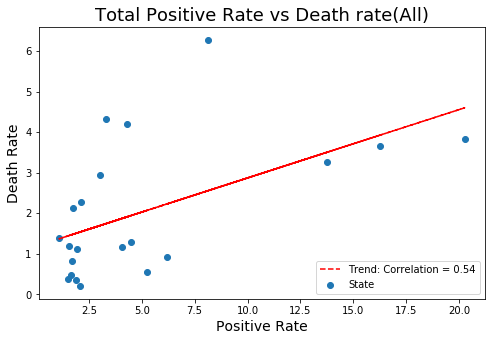

In [506]:
#Plot of death rate vs positive rate - not a true picture as death rate is maturing
plt.figure(figsize=(8,5))
plt.scatter(df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'positive_rate'], 
            df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'death_rate'], label="State")

z = np.polyfit(df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'positive_rate'], 
            df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'death_rate'], 1)
p = np.poly1d(z)

plt.plot(df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'positive_rate'],
         p(df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'positive_rate']), 
         color="red", linestyle='dashed', label="Trend: Correlation = "+str(round(corr_pos,2)))
plt.legend(loc="lower right")

plt.title("Total Positive Rate vs Death rate(All)", fontsize=18)
plt.xlabel("Positive Rate", fontsize=14)
plt.ylabel("Death Rate", fontsize=14)
plt.show()

In [511]:
corr_pos_active = df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'positive_rate'].corr(
    df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'death_rate_active'])

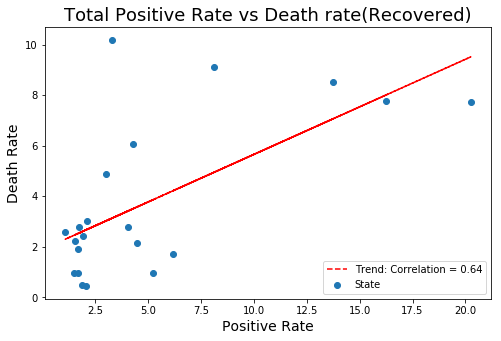

In [513]:
#Plot of death rate vs positive rate - not a true picture as death rate is maturing
plt.figure(figsize=(8,5))
plt.scatter(df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'positive_rate'], 
            df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'death_rate_active'], label="State")

z = np.polyfit(df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'positive_rate'], 
            df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'death_rate_active'], 1)
p = np.poly1d(z)
plt.plot(df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'positive_rate'],
         p(df_state_cases.loc[df_state_cases['State_code'].isin(top_20),'positive_rate']), 
         color="red", linestyle='dashed', label="Trend: Correlation = "+str(round(corr_pos_active,2)))
plt.legend(loc="lower right")

plt.title("Total Positive Rate vs Death rate(Recovered)", fontsize=18)
plt.xlabel("Positive Rate", fontsize=14)
plt.ylabel("Death Rate", fontsize=14)
plt.show()

### %Positive over time for Top-20 states

In [422]:
df_state_daily_tests.head()

,Date,State,tests,Positive,Unconfirmed,State_code,positive_rate,daily_tests,daily_cases,daily_positive_rate
0,2020-04-17,Andaman and Nicobar Islands,1222.0,12.0,181.0,AN,0.981997,NaN,NaN,NaN
1,2020-04-24,Andaman and Nicobar Islands,2433.0,27.0,246.0,AN,1.109741,1211.0,15.0,1.238646
2,2020-04-27,Andaman and Nicobar Islands,2742.0,33.0,106.0,AN,1.203501,309.0,6.0,1.941748
3,2020-05-01,Andaman and Nicobar Islands,3555.0,33.0,199.0,AN,0.928270,813.0,0.0,0.000000
4,2020-05-16,Andaman and Nicobar Islands,6541.0,33.0,136.0,AN,0.504510,2986.0,0.0,0.000000


In [404]:
df_state_daily_tests['positive_rate'] = df_state_daily_tests['Positive']*100/df_state_daily_tests['tests']

In [405]:
df_state_daily_tests['daily_tests'] = df_state_daily_tests.groupby(['State_code'])[
    'tests'].transform(lambda x: x.diff())
df_state_daily_tests['daily_cases'] = df_state_daily_tests.groupby(['State_code'])[
    'Positive'].transform(lambda x: x.diff()) 

In [406]:
df_state_daily_tests['daily_positive_rate'] = df_state_daily_tests['daily_cases']*100/df_state_daily_tests['daily_tests']

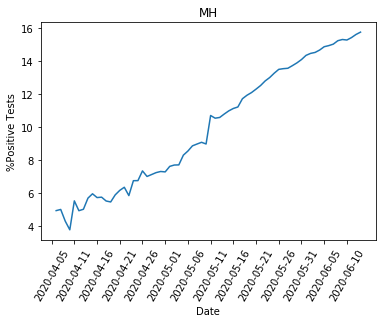

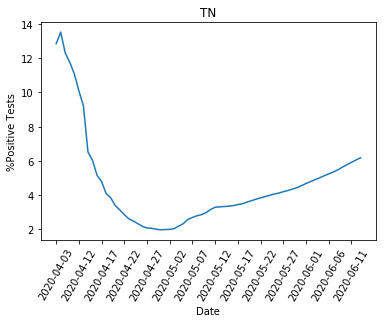

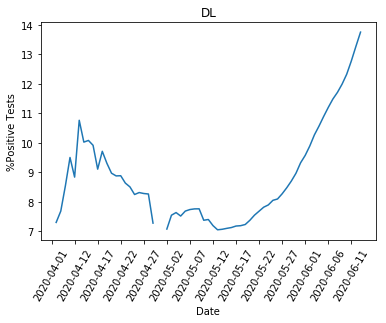

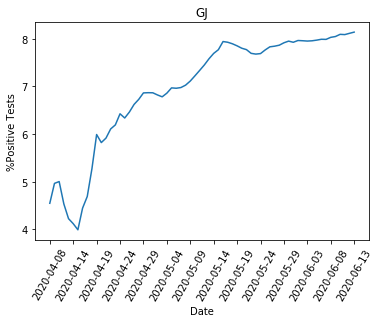

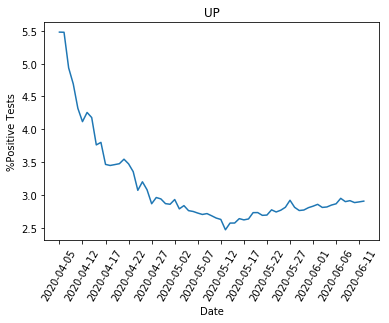

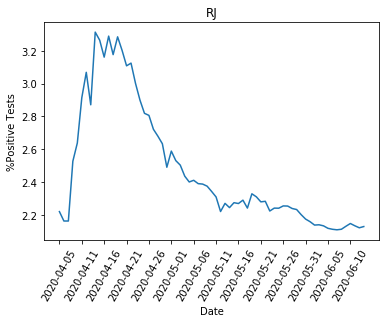

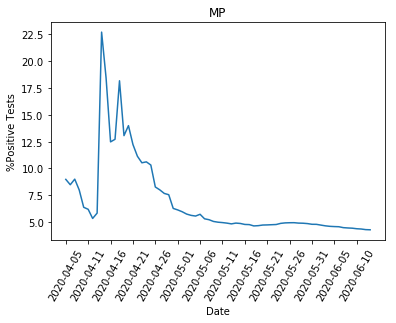

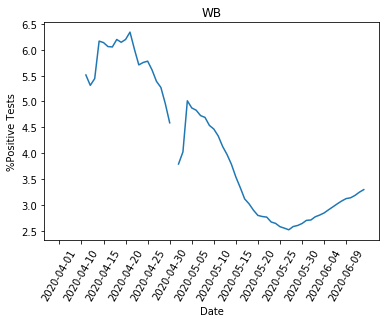

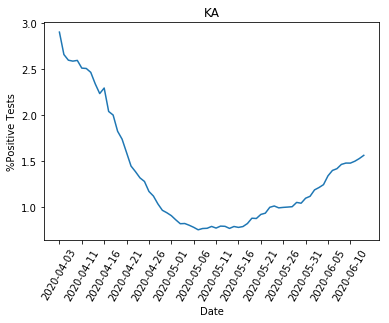

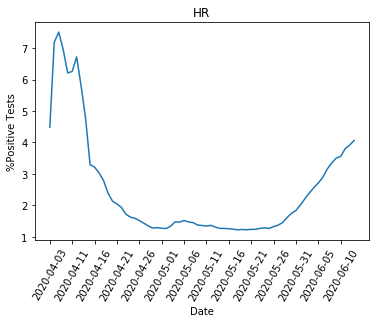

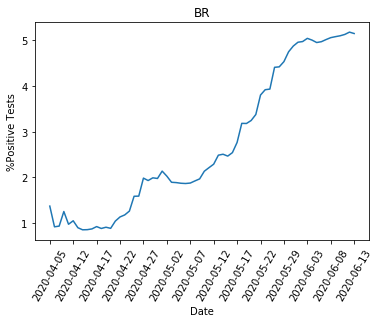

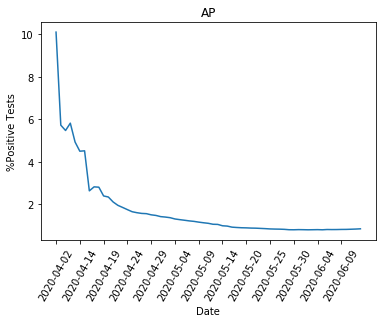

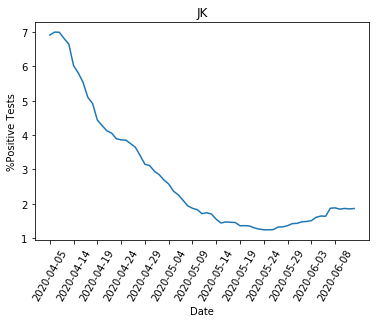

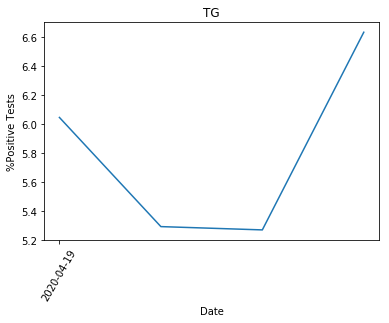

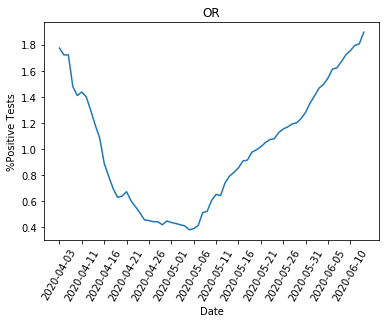

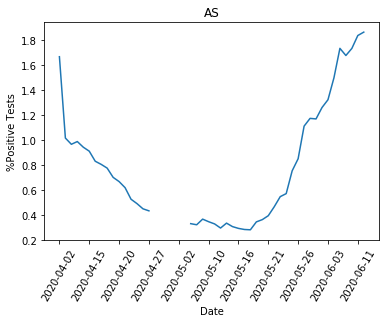

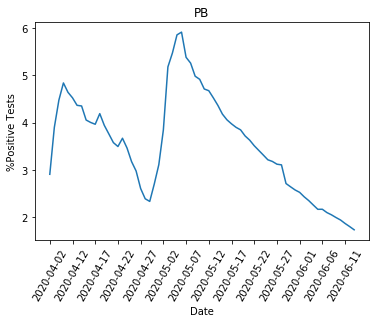

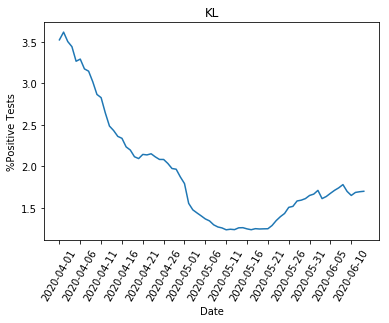

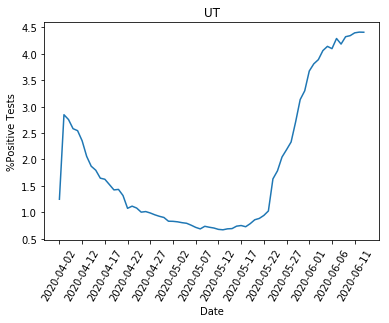

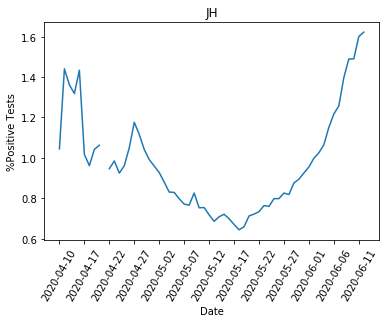

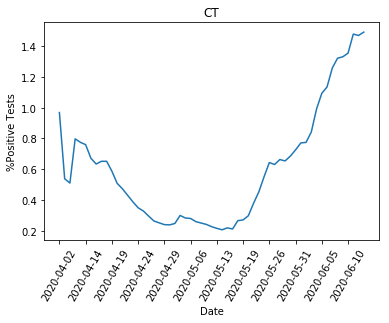

In [453]:
for state in top_20:
    plt.plot(df_state_daily_tests.loc[df_state_daily_tests['State_code']==state, 'positive_rate'].reset_index(drop=True))
    plt.xticks(np.arange(len(df_state_daily_tests.loc[df_state_daily_tests['State_code']==state, 'positive_rate']))[0::5], 
               df_state_daily_tests.loc[df_state_daily_tests['State_code']==state, 'Date'].dt.date[0::5], 
               rotation=60)
#     plt.ylim(0)
    plt.title(state)
    plt.xlabel('Date')
    plt.ylabel('%Positive Tests')
    plt.show()

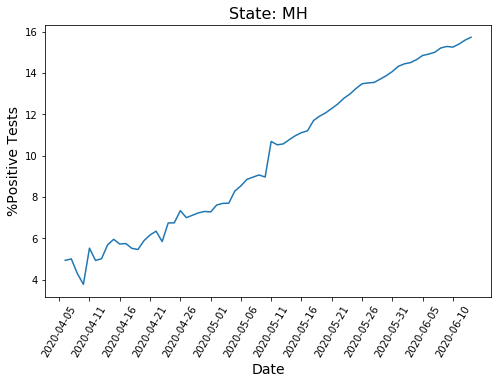

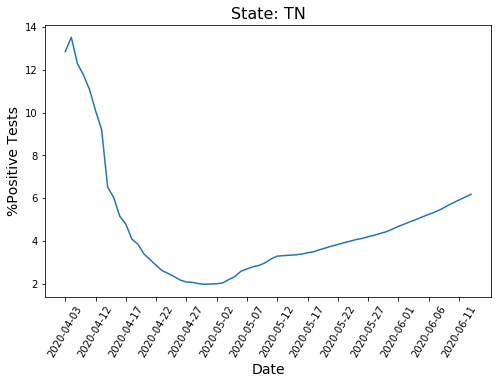

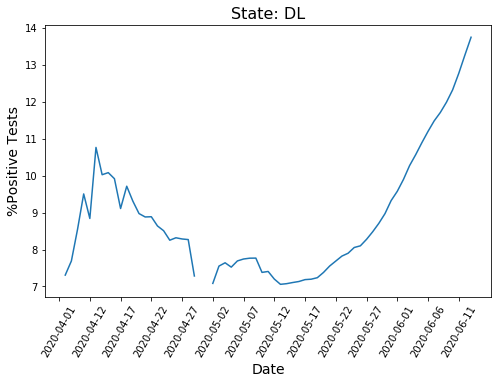

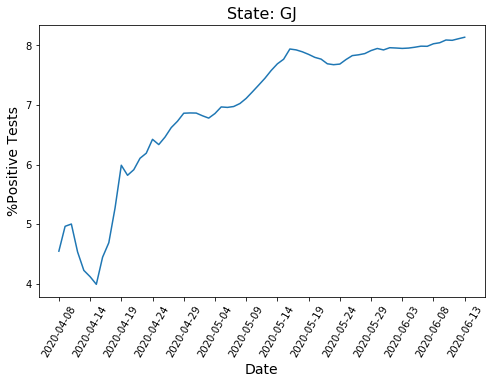

In [521]:
for state in [state for state in top_20 if state in ['MH', 'TN', 'TL', 'DL', 'GJ']]:
    plt.figure(figsize=(8,5))
    plt.plot(df_state_daily_tests.loc[df_state_daily_tests['State_code']==state, 'positive_rate'].reset_index(drop=True))
    plt.xticks(np.arange(len(df_state_daily_tests.loc[df_state_daily_tests['State_code']==state, 'positive_rate']))[0::5], 
               df_state_daily_tests.loc[df_state_daily_tests['State_code']==state, 'Date'].dt.date[0::5], 
               rotation=60)
#     plt.ylim(0)
    plt.title("State: "+state, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('%Positive Tests', fontsize=14)
    plt.show()

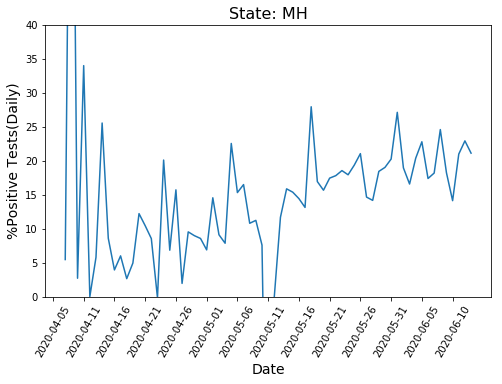

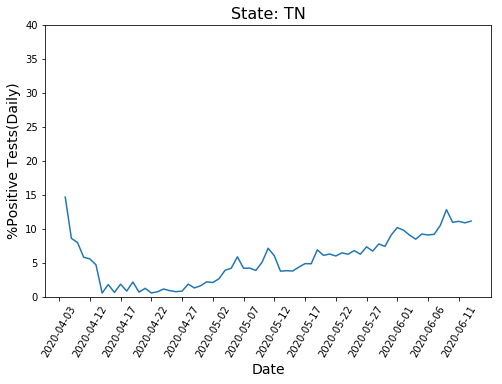

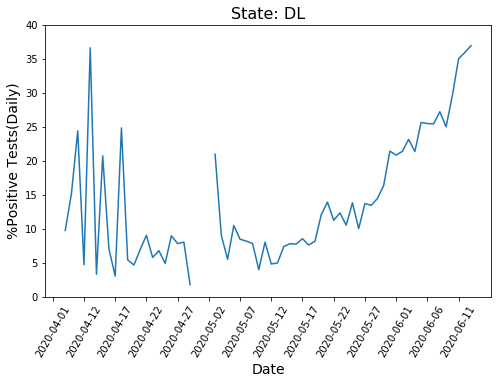

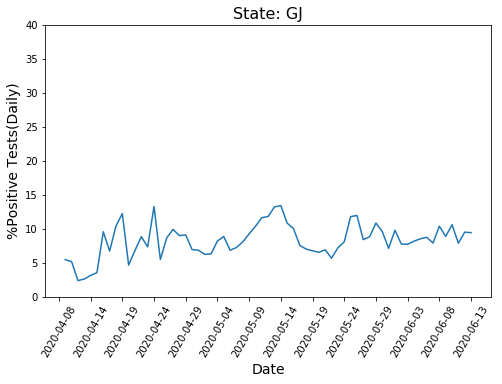

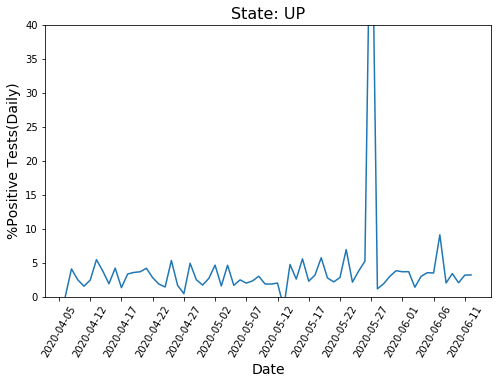

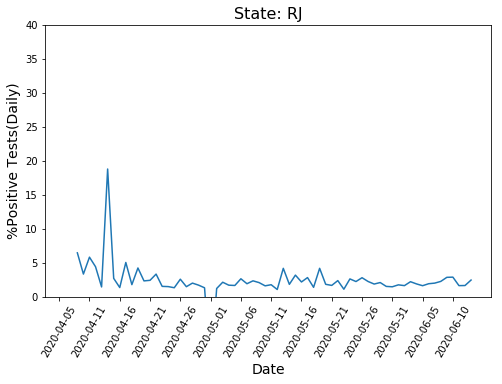

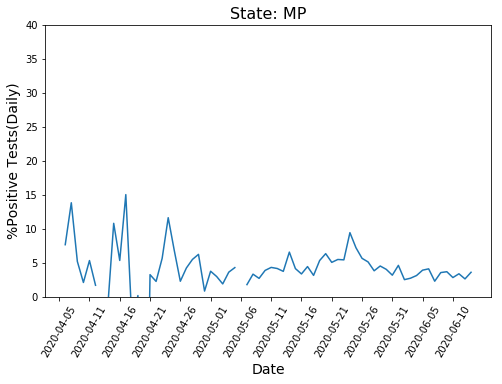

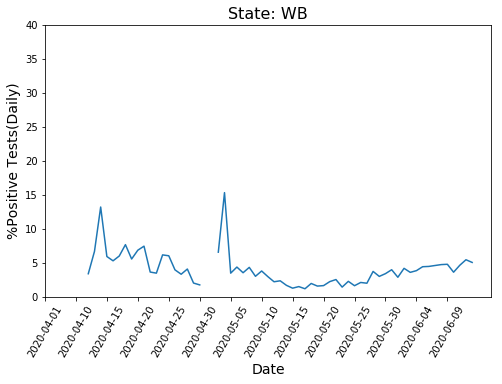

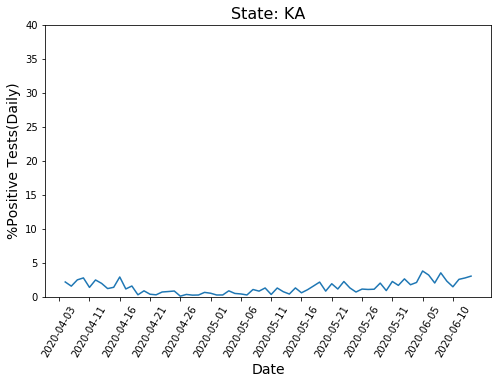

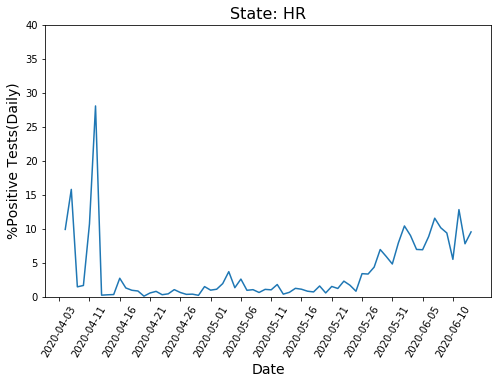

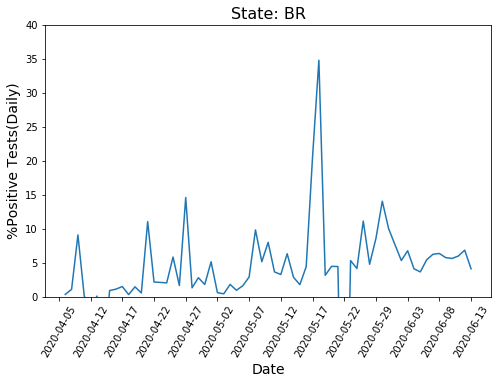

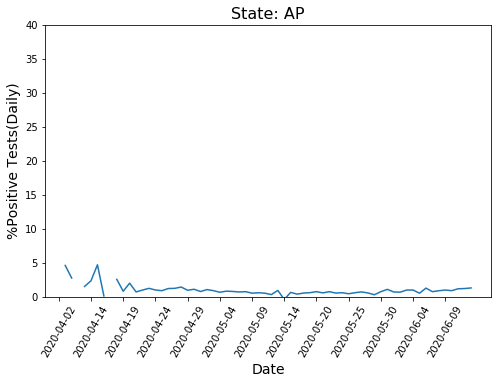

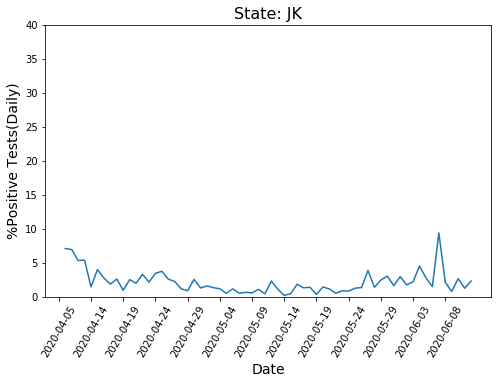

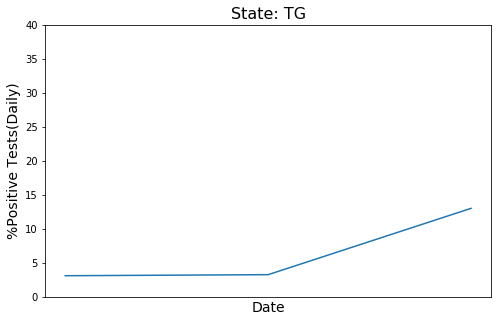

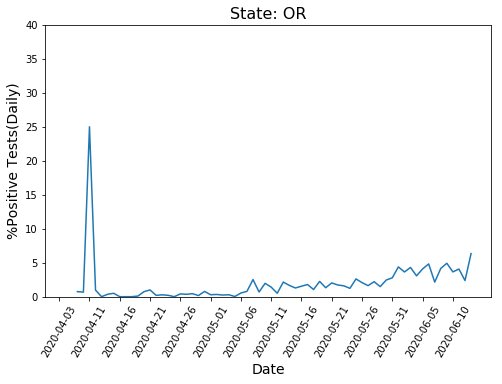

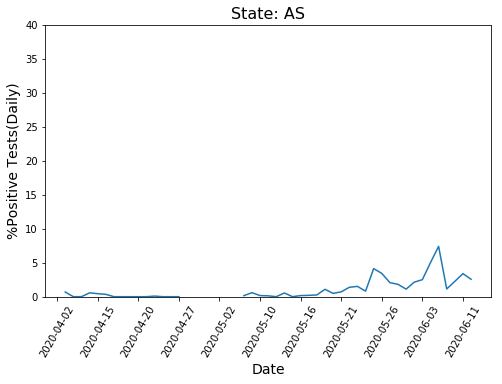

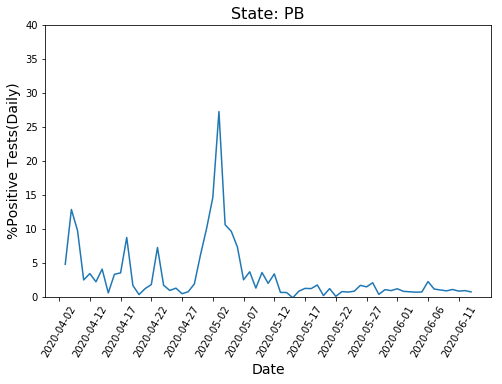

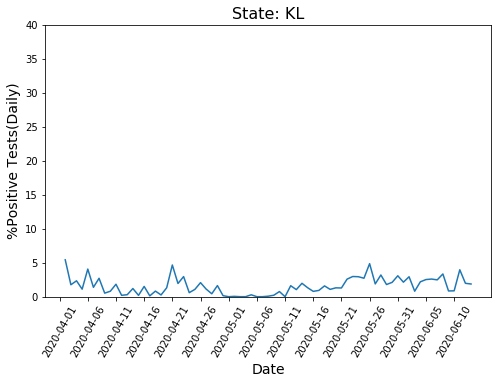

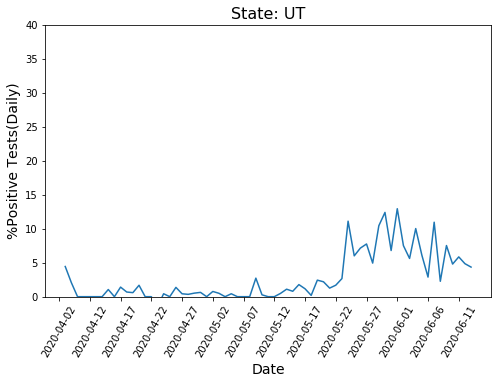

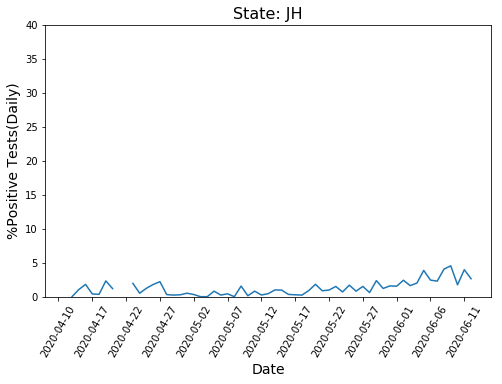

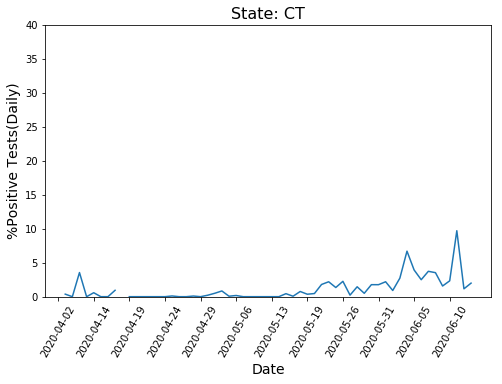

In [527]:
for state in top_20:
    plt.figure(figsize=(8,5))
    plt.plot(df_state_daily_tests.loc[df_state_daily_tests['State_code']==state, 'daily_positive_rate'].reset_index(drop=True))
    plt.xticks(np.arange(len(df_state_daily_tests.loc[df_state_daily_tests['State_code']==state, 'positive_rate']))[0::5], 
               df_state_daily_tests.loc[df_state_daily_tests['State_code']==state, 'Date'].dt.date[0::5], 
               rotation=60)
    plt.ylim((0,40))
    plt.title("State: "+state, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('%Positive Tests(Daily)', fontsize=14)
    plt.show()

In [371]:
df_state_daily_tests[df_state_daily_tests['State_code']=='MH']

,Date,State,tests,Positive,Unconfirmed,State_code,positive_rate,daily_tests,daily_cases,daily_positive_rate
1137,2020-05-04,Maharashtra,16008.0,NaN,0.0,MH,NaN,NaN,NaN,NaN
1138,2020-06-04,Maharashtra,17563.0,868.0,0.0,MH,4.942208,1555.0,NaN,NaN
1139,2020-07-04,Maharashtra,20308.0,1018.0,569.0,MH,5.012803,2745.0,150.0,5.464481
1140,2020-09-04,Maharashtra,20162.0,868.0,715.0,MH,4.305128,-146.0,-150.0,102.739726
1141,2020-10-04,Maharashtra,30000.0,1135.0,0.0,MH,3.783333,9838.0,267.0,2.713966
1142,2020-11-04,Maharashtra,31841.0,1761.0,0.0,MH,5.530605,1841.0,626.0,34.003259
1143,2020-12-04,Maharashtra,35668.0,1761.0,0.0,MH,4.937199,3827.0,0.0,0.000000
1144,2020-04-13,Maharashtra,39725.0,1996.0,0.0,MH,5.024544,4057.0,235.0,5.792457
1145,2020-04-14,Maharashtra,41071.0,2340.0,0.0,MH,5.697451,1346.0,344.0,25.557207
1146,2020-04-15,Maharashtra,45142.0,2690.0,0.0,MH,5.958974,4071.0,350.0,8.597396
